# Step 1: Loading the Data and Filtering for Chosen Zipcodes

**PURPOSE:** This notebook aims to suggest potential locations for investing in U.S. real estate, based on historical data on the average housing prices.
\
\
**BUSINESS PROBLEM:** The clients utilizing this notebook are people who intend to buy houses purely for investment purposes and not for residence. For this reason, in-depth considerations for each region and neighborhood are not included - only monthly price movements will be considered.
\
\
**DATA:** Data used in this notebook contains the average monthly house prices from April 1996 to April 2018 (22 year span), organized by zipcode. 
\
The dataframe contains 14722 rows and 272 columns.
\
This data can be accessed on the Zillow website (https://www.zillow.com/research/data/).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima# Step 1: Loading the Data and Filtering for Chosen Zipcodes

In [ ]:
# df_lifestyle.to_csv('clickhole_lifestyle.csv')

In [48]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [49]:
# user can adjust budget and maximum price range here
budget = 450 * 1000  # represents budget in dollars
price_multiple = 3  # represents the maximum amount of times of budget that the user is willing to accept

sr = 0.20  # Size Rank
pr = 0.20  # Price Range
cv = 0.60  # Coefficient of Variance

# formula = sr*size_rank + mp*mean_price + cv*coeff_variance

In [50]:
df['City'] = df['City'] + ', ' + df['State']  # combine city and state
df.rename(columns={"City": "Location", "RegionName": "Zipcode"}, inplace=True)  # rename columns for easy interpretation 
df.drop(['RegionID', 'State', 'Metro', 'CountyName'], axis=1, inplace=True)  # get rid of unnecessary columns
df.dropna(inplace=True)  # drop rows containing null values
df.reset_index(inplace=True)  # reset index after getting rid of null values
df['index'] = abs(df.index - 13683) / (len(df) - 1)  # new SizeRank that ranges from 1 to 0 (1 means highest size)

In [51]:
df.head()

,index,Zipcode,Location,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,1.000000,60657,"Chicago, IL",1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,0.999927,75070,"McKinney, TX",2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,0.999854,77494,"Katy, TX",3,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,0.999781,60614,"Chicago, IL",4,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,0.999708,79936,"El Paso, TX",5,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [52]:
# this represents how much the median house prices deviate from the budget. 
# 1 means that median price of that region is 100% of the budget that is set by the user.
price_deviation = df['2018-04'].map(lambda x: x / budget)
price_deviation.describe()

count    13684.000000
mean         0.653039
std          0.723791
min          0.030667
25%          0.304667
50%          0.456889
75%          0.738500
max         16.414667
Name: 2018-04, dtype: float64

In [53]:
price_deviation.quantile(.9859)

3.018692266666667

In [54]:
price_deviation.quantile(.9927)

4.0011993333332905

In [55]:
# constant that measures the price deviation from 0 to 1.
# 1 represents deviation equal to the multiple that is set by the user in the beginning.
price_deviation_c = price_deviation / price_multiple

In [56]:
price_deviation_c.quantile(.9927)

1.3337331111110968

In [57]:
price_deviation_c.describe()

count    13684.000000
mean         0.217680
std          0.241264
min          0.010222
25%          0.101556
50%          0.152296
75%          0.246167
max          5.471556
Name: 2018-04, dtype: float64

In [58]:
# Median house prices that exceed the set multiple would all recieve maximum penalty.
price_deviation_c[price_deviation_c > 1] = 1
# Price deviation is set from 0 to 1, where 1 represents no penalty and 0 represents maximum penalty
price_deviation_c = abs(price_deviation_c - 1)

In [59]:
distribution = pd.DataFrame(columns=['std', 'mean', 'coeff_variance'])
# Standard deviation of average monthly prices
distribution['std'] = df.loc[:,'1996-04':'2018-04'].std(axis=1)
# Mean of average monthly prices
distribution['mean'] = df.loc[:,'1996-04':'2018-04'].mean(axis=1)
# Coefficient of Variance
distribution['coeff_variance'] = distribution['std'] / distribution['mean']

# This dataframe contains std, mean, and coefficient of variance.
distribution.head()

,std,mean,coeff_variance
0,190821.103965,743978.867925,0.256487
1,33537.101427,219655.849057,0.152680
2,37730.794353,262110.566038,0.143950
3,231225.944628,974139.245283,0.237364
4,18167.079218,101875.471698,0.178326


In [68]:
# Now, apply the formula with the set weights of each contributing factor:
size_rank = df['index']
price_range = price_deviation_c
coeff_variance = distribution['coeff_variance']

# This pandas series represents the final 'score' of each zipcode
formula = sr*size_rank + pr*price_range + cv*coeff_variance

In [72]:
# compile all metrics related values to a single dataframe called 'metrics'
metrics = pd.DataFrame()
metrics['size_rank'] = size_rank
metrics['price_range'] = price_range
metrics['coeff_variance'] = coeff_variance
metrics['formula'] = formula

In [75]:
metrics.head()

,size_rank,price_range,coeff_variance,formula
0,1.000000,0.236593,0.256487,0.401211
1,0.999927,0.761630,0.152680,0.443919
2,0.999854,0.755630,0.143950,0.437467
3,0.999781,0.031852,0.237364,0.348745
4,0.999708,0.910000,0.178326,0.488937


In [107]:
# Calculate Return on Investment for the past 22 years (Apr 1996 - Apr 2018)
roi = (df['2018-04'] / df['1996-04']) - 1
roi = pd.DataFrame(roi, index=range(len(roi)))

# Then, store the indexes of the zipcodes that yielded top 10% ROI.
highest_roi = roi[roi > roi.quantile(.90)].dropna().sort_values(by=0, ascending=False).index
# choices sorted by highest formula value
top_choices = pd.DataFrame(formula).sort_values(0, ascending = False).index

# final choices are the zipcodes with highest formula value that has the top 10% ROI
final_choices = df.loc[top_choices].loc[highest_roi].index

In [132]:
data = df.loc[final_choices].head()
data.set_index('Zipcode',inplace=True)
data.rename(index={7302:'73020'}, inplace=True)
data.index = data.index.map(str)

In [133]:
data

,index,Location,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
Zipcode,,,,,,,,,,,,,,,,,,,,,
11211,0.991668,"New York, NY",118,133200.0,132900.0,132500.0,132200.0,131800.0,131600.0,131500.0,...,1405100,1406400,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700
11222,0.916904,"New York, NY",1156,149200.0,148400.0,147500.0,146600.0,146000.0,145600.0,145400.0,...,1598000,1623800,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100
11216,0.965943,"New York, NY",476,146100.0,146600.0,147200.0,147700.0,148400.0,149300.0,150200.0,...,1452000,1506100,1553100,1567700,1559700,1545700,1540200,1553600,1578400,1598700
73020,0.986333,"Jersey City, NJ",192,137200.0,137800.0,138500.0,139100.0,139600.0,140100.0,140700.0,...,1340200,1372300,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300
11215,0.992472,"New York, NY",107,225700.0,227500.0,229400.0,231600.0,234100.0,236900.0,239800.0,...,2173600,2201100,2244400,2266100,2275800,2287100,2288900,2265300,2244900,2243900


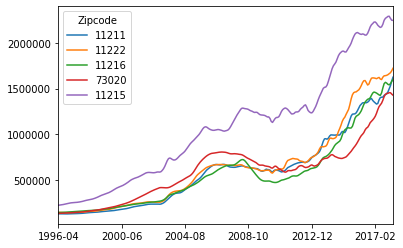

In [134]:
data.loc[:,'1996-04':'2018-04'].T.plot()

# Step 2: Data Preprocessing

In [141]:
best_five = data.drop(['index', 'Location', 'SizeRank'], axis=1).T
best_five.index = pd.to_datetime(best_five.index)
best_five

Zipcode,11211,11222,11216,73020,11215
1996-04-01,133200.0,149200.0,146100.0,137200.0,225700.0
1996-05-01,132900.0,148400.0,146600.0,137800.0,227500.0
1996-06-01,132500.0,147500.0,147200.0,138500.0,229400.0
1996-07-01,132200.0,146600.0,147700.0,139100.0,231600.0
1996-08-01,131800.0,146000.0,148400.0,139600.0,234100.0
...,...,...,...,...,...
2017-12-01,1463100.0,1651200.0,1545700.0,1447800.0,2287100.0
2018-01-01,1496100.0,1661800.0,1540200.0,1454900.0,2288900.0
2018-02-01,1531100.0,1672800.0,1553600.0,1453900.0,2265300.0
2018-03-01,1581900.0,1694000.0,1578400.0,1439500.0,2244900.0


# Step 3: EDA and Visualization

In [142]:
def dftest_results(data):
    Dickey_Fuller = {}
    for zipcode in data:
        dftest = adfuller(data[zipcode])
        Dickey_Fuller[zipcode] = dftest[0:4]
    DF_Test = pd.DataFrame.from_dict(Dickey_Fuller)
    DF_Test.index = ['Test Statistic', 'p-value', '#Lags Used', '#Observations Used']
    return DF_Test

In [424]:
dftest_results(best_five)

,11211,11222,11216,7302,11215
Test Statistic,1.988403,1.024405,0.203156,-0.549950,0.464626
p-value,0.998658,0.994517,0.972438,0.881895,0.983757
#Lags Used,15.000000,16.000000,16.000000,16.000000,16.000000
#Observations Used,249.000000,248.000000,248.000000,248.000000,248.000000


In [473]:
best_five

Zipcode,11211,11222,11216,7302,11215
1996-04-01,133200.0,149200.0,146100.0,137200.0,225700.0
1996-05-01,132900.0,148400.0,146600.0,137800.0,227500.0
1996-06-01,132500.0,147500.0,147200.0,138500.0,229400.0
1996-07-01,132200.0,146600.0,147700.0,139100.0,231600.0
1996-08-01,131800.0,146000.0,148400.0,139600.0,234100.0
...,...,...,...,...,...
2017-12-01,1463100.0,1651200.0,1545700.0,1447800.0,2287100.0
2018-01-01,1496100.0,1661800.0,1540200.0,1454900.0,2288900.0
2018-02-01,1531100.0,1672800.0,1553600.0,1453900.0,2265300.0
2018-03-01,1581900.0,1694000.0,1578400.0,1439500.0,2244900.0


In [467]:
best_five[11211].iloc[0]

133200.0

In [474]:
len(best_five.columns)

5

In [484]:
# Monthly returns for each zipcode
returns = pd.DataFrame()
for zipcode in best_five.columns:
    returns[zipcode] = (best_five[zipcode].shift(periods=1) / best_five[zipcode]) - 1

In [489]:
returns.dropna(inplace=True)

,11211,11222,11216,7302,11215
Test Statistic,-2.845357,-2.742244,-2.275457,-1.815001,-2.734080
p-value,0.052081,0.067009,0.180006,0.373040,0.068324
#Lags Used,15.000000,14.000000,16.000000,14.000000,16.000000
#Observations Used,248.000000,249.000000,247.000000,249.000000,247.000000


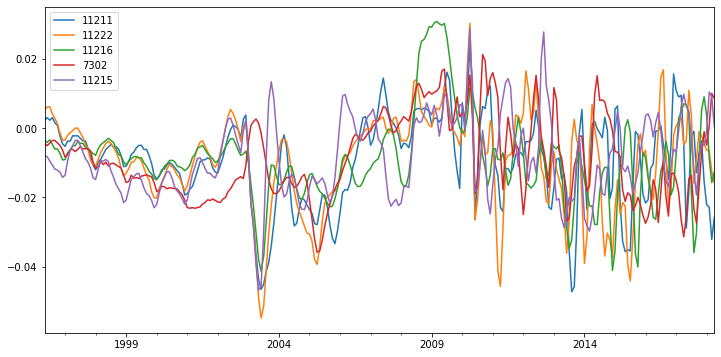

In [490]:
returns.plot(figsize=(12,6));
dftest_results(returns)

In [ ]:
# create new notebook - final model
# build a final model for each - add 1 to differencing
# feed in undifferenced monthly returns
# RMSE would be RMSE of monthly returns.
# Loops to get to original dollar values.

# returns df into autoarima
# DF, PACF provides starting point (pdq to start)
# 1 or 2 below pdq that you got from eda

,11211,11222,11216,7302,11215
Test Statistic,-6.520122e+00,-6.860757e+00,-4.949550,-6.604221e+00,-4.780046
p-value,1.047252e-08,1.604808e-09,0.000028,6.618658e-09,0.000059
#Lags Used,1.300000e+01,1.300000e+01,15.000000,1.300000e+01,16.000000
#Observations Used,2.490000e+02,2.490000e+02,247.000000,2.490000e+02,246.000000


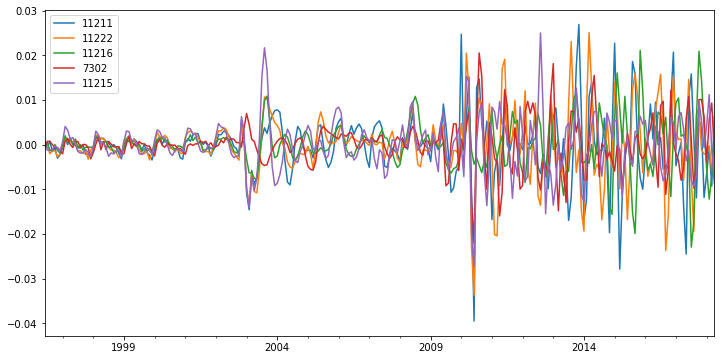

In [493]:
diff_returns = (returns).diff(periods=1).dropna()
diff_returns.plot(figsize=(12,6))a;
dftest_results(diff_returns)

In [521]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 5: ARIMA Modeling

In [60]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [538]:
tts_cutoff = round(len(diff_returns) * 0.80)
train, test = diff_returns.iloc[:tts_cutoff], diff_returns.iloc[tts_cutoff:]

In [537]:
diff_returns.columns

Int64Index([11211, 11222, 11216, 7302, 11215], dtype='int64')

In [575]:
# !pip install pmdarima

In [576]:
from pmdarima.arima import auto_arima

In [580]:
autoarima_params = {}

for col in diff_returns.columns:
    auto = auto_arima(diff_returns[col], max_order=None, start_p=1, start_q=1, 
                      max_p=10, max_q=10, max_d=5, seasonal=False)   
    autoarima_params[col] = auto.get_params()['order']

In [581]:
autoarima_params

{11211: (0, 0, 5),
 11222: (5, 0, 1),
 11216: (2, 0, 0),
 7302: (0, 0, 3),
 11215: (5, 0, 4)}

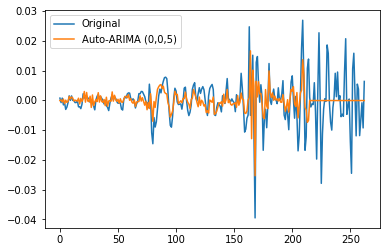

(0.004660212948292422, 0.01076915065599195)

In [612]:
auto1 = ARIMA(train.iloc[:,0], order=autoarima_params[11211], freq='MS').fit()
a_trainpreds1 = pd.DataFrame(np.array(auto1.predict()), index=train.index)
a_testpreds1 = pd.DataFrame(auto1.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,0]), label='Original')
plt.plot(np.append(a_trainpreds1, a_testpreds1[0]), label='Auto-ARIMA (0,0,5)')
plt.legend()
plt.show()

a_train1_rmse = mean_squared_error(train.iloc[:,0], a_trainpreds1)**0.5
a_test1_rmse = mean_squared_error(test.iloc[:,0], a_testpreds1)**0.5
a_train1_rmse, a_test1_rmse

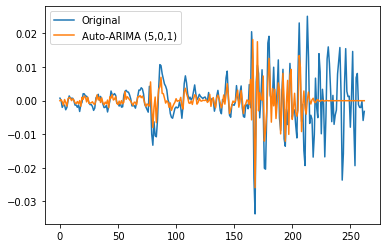

(0.0044764956841946025, 0.0104643429091325)

In [613]:
auto2 = ARIMA(train.iloc[:,1], order=autoarima_params[11222], freq='MS').fit()
a_trainpreds2 = pd.DataFrame(np.array(auto2.predict()), index=train.index)
a_testpreds2 = pd.DataFrame(auto2.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,1]), label='Original')
plt.plot(np.append(a_trainpreds2, a_testpreds2[0]), label='Auto-ARIMA (5,0,1)')
plt.legend()
plt.show()

a_train2_rmse = mean_squared_error(train.iloc[:,1], a_trainpreds2)**0.5
a_test2_rmse = mean_squared_error(test.iloc[:,1], a_testpreds2)**0.5
a_train2_rmse, a_test2_rmse

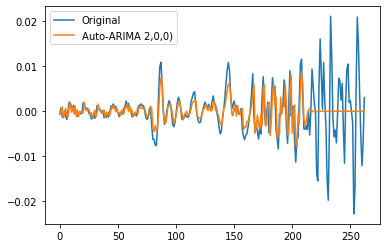

(0.0024039846039167687, 0.009423114499128086)

In [614]:
auto3 = ARIMA(train.iloc[:,2], order=autoarima_params[11216], freq='MS').fit()
a_trainpreds3 = pd.DataFrame(np.array(auto3.predict()), index=train.index)
a_testpreds3 = pd.DataFrame(auto3.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,2]), label='Original')
plt.plot(np.append(a_trainpreds3, a_testpreds3[0]), label='Auto-ARIMA 2,0,0)')
plt.legend()
plt.show()

a_train3_rmse = mean_squared_error(train.iloc[:,2], a_trainpreds3)**0.5
a_test3_rmse = mean_squared_error(test.iloc[:,2], a_testpreds3)**0.5
a_train3_rmse, a_test3_rmse

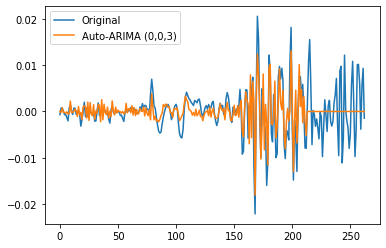

(0.003317223725517227, 0.006288091857031356)

In [615]:
auto4 = ARIMA(train.iloc[:,3], order=autoarima_params[7302], freq='MS').fit()
a_trainpreds4 = pd.DataFrame(np.array(auto4.predict()), index=train.index)
a_testpreds4 = pd.DataFrame(auto4.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,3]), label='Original')
plt.plot(np.append(a_trainpreds4, a_testpreds4[0]), label='Auto-ARIMA (0,0,3)')
plt.legend()
plt.show()

a_train4_rmse = mean_squared_error(train.iloc[:,3], a_trainpreds4)**0.5
a_test4_rmse = mean_squared_error(test.iloc[:,3], a_testpreds4)**0.5
a_train4_rmse, a_test4_rmse

/Users/taejoon/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


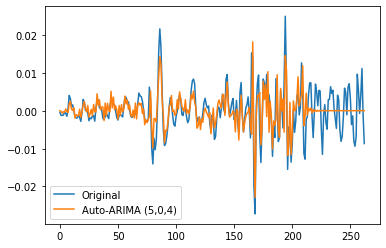

(0.0037541022865996425, 0.005733597451328089)

In [616]:
auto5 = ARIMA(train.iloc[:,4], order=autoarima_params[11215], freq='MS').fit()
a_trainpreds5 = pd.DataFrame(np.array(auto5.predict()), index=train.index)
a_testpreds5 = pd.DataFrame(auto5.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,4]), label='Original')
plt.plot(np.append(a_trainpreds5, a_testpreds5[0]), label='Auto-ARIMA (5,0,4)')
plt.legend()
plt.show()

a_train5_rmse = mean_squared_error(train.iloc[:,4], a_trainpreds5)**0.5
a_test5_rmse = mean_squared_error(test.iloc[:,4], a_testpreds5)**0.5
a_train5_rmse, a_test5_rmse

# Step 6: Interpreting Results

In [625]:
rmse

,11211,11222,11216,7302,11215
Train RMSE,NaN,NaN,NaN,NaN,NaN
Test RMSE,NaN,NaN,NaN,NaN,NaN


In [629]:
print(a_train1_rmse, a_test1_rmse)
print(a_train2_rmse, a_test2_rmse)
print(a_train3_rmse, a_test3_rmse)
print(a_train4_rmse, a_test4_rmse)
print(a_train5_rmse, a_test5_rmse)

0.004660212948292422 0.01076915065599195
0.0044764956841946025 0.0104643429091325
0.0024039846039167687 0.009423114499128086
0.003317223725517227 0.006288091857031356
0.0037541022865996425 0.005733597451328089


In [634]:
print(a_testpreds1.mean())
print(a_testpreds2.mean())
print(a_testpreds3.mean())
print(a_testpreds4.mean())
print(a_testpreds5.mean())

0   -0.000257
dtype: float64
0   -0.000068
dtype: float64
0   -0.000183
dtype: float64
0   -0.000084
dtype: float64
0    0.000031
dtype: float64


Best zipcode to invest is the fifth zipcode - it has the lowest test RMSE and the third lowest train RMSE. It also has the highest average predicted growth out of the five top zipcodes.

11215 is the zipcode for Park Slope, located in Brooklyn, NY.

In [2]:
## need to interpret the coefficients and undiff twice...

In [3]:
## model interpretations and graphical representation needed

In [ ]:
## print figures accordingly and include in readme